Feature extraction from images as pretrained image features for MUSE

In [7]:
# loading some basic packages
from google.colab import drive
import os
import sys
from tqdm import tqdm
#import torch
#os.environ['TORCH'] = torch.__version__
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Load the presaved .tar file that contains single cell images (nuclear and membrane) for MUSE input.

In [9]:
import  tarfile
tar = tarfile.open("/content/drive/MyDrive/MaxFuse_related/MUSE_related/forMUSE_images_tonsil47294_v2.tar.gz")
#tar.getmembers()

In [10]:
import re
import numpy as np

for member in tar.getmembers():
    loc = str(member)
    result = re.search('\'(.*)\'', loc)
    dir = result.group(1)
    split = dir.split('/')

    if len(split) == 3:
      if split[2][0] != '.':
        # here is save to extract data
        #print(split[2])
        f=tar.extractfile(member)

        content=f.read()
        na = np.frombuffer(content, dtype = 'uint8')
        an = na[128:]
        an.shape = (55, 55, 3)
#tar.close()

check if single cell images look correct.

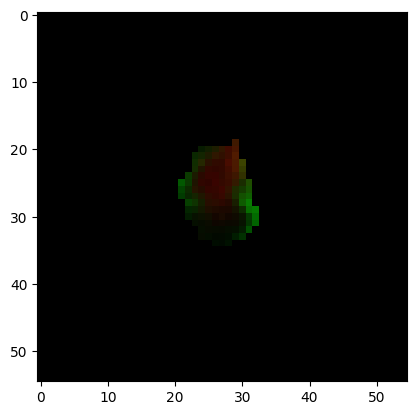

In [11]:
import matplotlib.pyplot as plt

plt.imshow(an)
plt.show()

We first do the pre-training by inception, full training still explode the RAM.

In [12]:
'''
Inference of inception-v3 model with pretrained parameters on ImageNet
'''

import tensorflow.compat.v1 as tf

# To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()
import tensorflow_hub as hub
import numpy as np
import cv2
import pandas as pd

# Load saved inception-v3 model
module = hub.Module("/content/drive/MyDrive/MaxFuse_related/MUSE_related/muse_github/inception_v3")

# images should be resized to 299x299
input_imgs = tf.placeholder(tf.float32, shape=[None, 299, 299, 3])
features = module(input_imgs)
image_no = 47294 # cell numbers, subset of whole dataset to reduce run time and memory usage
res = []

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #img_all = np.zeros([image_no, 299, 299, 3])

    i=0
    for member in tqdm(tar.getmembers()):
      loc = str(member)
      result = re.search('\'(.*)\'', loc)
      dir = result.group(1)
      split = dir.split('/')

      if len(split) == 3:
        if split[2][0] != '.':
          # here is save to extract data
          f=tar.extractfile(member)
          content=f.read()
          na = np.frombuffer(content, dtype = 'uint8')
          an = na[128:]
          an.shape = (55, 55, 3)

          ###
          resized = cv2.resize(an, (299, 299))
          fea = sess.run(features, feed_dict={input_imgs: resized[None, :, :, :]})
          #img_all[i, :, :, :] = resized
          i = i + 1
          res.append(fea)

    #fea = sess.run(features, feed_dict={input_imgs: img_all})
    #np.save('/content/drive/MyDrive/MaxFuse_related/MUSE_related/Inception_img_feature_tar_full_tonsilv2_47294.npy', fea)


100%|██████████| 47295/47295 [08:05<00:00, 97.45it/s] 


In [13]:
res = np.array(res).squeeze(1)

In [16]:
np.save('/content/drive/MyDrive/MaxFuse_related/MUSE_related/Inception_img_feature_tar_full_tonsilv2_47294.npy', res)

In [17]:
res.shape

(47294, 2048)

In [18]:
## since read sequence is not 0-53,500 we need to re-seq it

import re
import numpy as np

ll = []
llreal = []
i = 0
for member in tar.getmembers():
    loc = str(member)
    result = re.search('\'(.*)\'', loc)
    dir = result.group(1)
    split = dir.split('/')

    if len(split) == 3:
      if split[2][0] != '.':
        # here is save to extract data
        imnum = int(split[2][4:-4])
        ll.append(imnum)
        llreal.append(i)
        i=i+1

#tar.close()

In [19]:
realidx = [ ll.index(x) if x in ll else None for x in llreal ]

In [20]:
len(ll)

47294

In [21]:
np.save('/content/drive/MyDrive/MaxFuse_related/MUSE_related/realidx_full_tonsilv2.npy',realidx)